In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, classification_report
import matplotlib.pyplot as plt

%matplotlib inline

## Data Cleanup

In [2]:
#import users data
users = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1", index_col='object_id', 
                    dtype={'invited_by_user_id':np.object})

#convert last session and creation time to datetimes
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
users['creation_time'] = pd.to_datetime(users['creation_time'])

#fill missing last session with original creation time
users['last_session_creation_time'] = users['last_session_creation_time'].fillna(users['creation_time'])

#calculate the time between creation and the most recent session
users['time_between'] = users['last_session_creation_time'] - users['creation_time']
users['time_between'] = users['time_between'].apply(lambda x: float(x.days))

print(users.info())
print(users.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 10 columns):
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null object
time_between                  12000 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(3), object(4)
memory usage: 1.3+ MB
None
                creation_time               name                       email  \
object_id                                                                      
1         2014-04-22 03:53:30     Clausen August    AugustCClausen@yahoo.com   
2         2013-11-15 03:45:04   

In [3]:
#import usage data
usage = pd.read_csv('takehome_user_engagement.csv')

#convert time_stamp to datetime
usage['time_stamp'] = pd.to_datetime(usage['time_stamp'])

print(usage.info())
print(usage.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB
None
           time_stamp  user_id  visited
0 2014-04-22 03:53:30        1        1
1 2013-11-15 03:45:04        2        1
2 2013-11-29 03:45:04        2        1
3 2013-12-09 03:45:04        2        1
4 2013-12-25 03:45:04        2        1


In [4]:
#calc total visits per user, join to users table
total_visits = usage.user_id.value_counts()
total_visits = total_visits.rename('total_visits')
users = users.join(total_visits)
users['total_visits'] = users['total_visits'].fillna(0)


In [5]:
#determine if a user adopted
#criteria = 3 or more visits in any 7 day period

#get a list of unique user IDs
unique_users = usage.user_id.unique()

#instantiate a dict to hold user adopted classification
user_adopted ={}

#loop over the unique users
for u in unique_users:
    #if user only ever signs on fewer than three times can't possible adobt
    user_usage = usage[usage.user_id == u]
    if len(user_usage)<3:
        user_adopted[u]=0
    else:
        #resample to sum number of signons each day, fill missing days with 0
        usage_day = user_usage.resample('D', on='time_stamp')['visited'].sum().fillna(0)
        #calculate 7-day rolling sum and get max number of signons
        usage_rolling = usage_day.rolling(7, min_periods=1).sum().max()
        #if max value is >=3 then the user adopted otherwise they did not
        if usage_rolling >= 3:
            user_adopted[u]=1
        else:
            user_adopted[u]=0

#convert dict to a dataframe, add adoption classification to user table
user_adopted = pd.DataFrame.from_dict(user_adopted, orient='index')
user_adopted.columns = ['adopted']
user_adopted.index.name = 'user_id'

users = users.join(user_adopted, how='left')
#classify any user that had no usage data an not-adopted
users['adopted'] = users['adopted'].fillna(0)

print(users.info())
print(users.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 12 columns):
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null object
time_between                  12000 non-null float64
total_visits                  12000 non-null float64
adopted                       12000 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(3), object(4)
memory usage: 1.5+ MB
None
                creation_time               name                       email  \
object_id                                                                      
1     

In [11]:
#print the number of users who adopted and who did not (1=adopted)
print(users.adopted.value_counts())

0.0    10398
1.0     1602
Name: adopted, dtype: int64


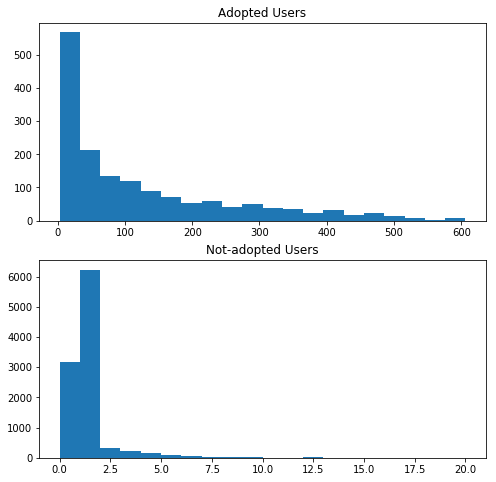

In [17]:
#plot histograms of the number visits
adopted = users[users.adopted == 1]
not_adopted = users[users.adopted == 0]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8,8))
ax1.hist(adopted['total_visits'], bins=20)
ax1.set_title('Adopted Users')

ax2.hist(not_adopted['total_visits'], bins=20)
ax2.set_title('Not-adopted Users')

plt.show()

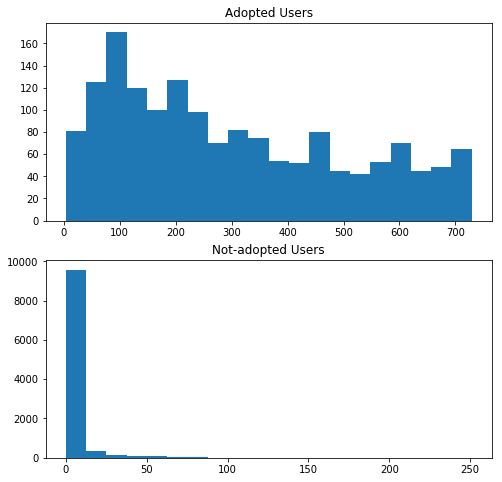

In [16]:
#plot histograms of the number of days between first and last session time
adopted = users[users.adopted == 1]
not_adopted = users[users.adopted == 0]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8,8))
ax1.hist(adopted['time_between'], bins=20)
ax1.set_title('Adopted Users')

ax2.hist(not_adopted['time_between'], bins=20)
ax2.set_title('Not-adopted Users')

plt.show()

## Prediction

In [6]:
#split data into labels and features
labels = users.adopted
features = users[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'time_between', 'total_visits']]#
features = pd.get_dummies(features, drop_first=True)

#split labels and features into trainig and test set
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state=24)

I chose not to use any creation_time, last_session_creation_time, name, or email because these fields would not be relevant to future users. I also chose not to use the org_id or invited_by_user_id as these are actually categorical variables and there would be so many categories for each I felt as though it would dilute the prediction.

In [8]:
#instantiate logistic regression
lr = LogisticRegression()
#fit the model
lr.fit(x_train, y_train)

#predict the outcomes of the test set
y_pred = lr.predict(x_test)

#print accuracy score and classification report
print('Score:', round(lr.score(x_test, y_test), 3))
print(classification_report(y_test, y_pred))


Score: 0.988
             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99      2073
        1.0       0.98      0.93      0.95       327

avg / total       0.99      0.99      0.99      2400



In [9]:
#Print the odds ratios for each of the model parameters
cols = list(x_test.columns)
coefs = lr.coef_

for x, y in zip(cols, coefs[0]):
    print(x + ": " + str(round(np.exp(y), 3)))


opted_in_to_mailing_list: 0.714
enabled_for_marketing_drip: 0.66
time_between: 0.943
total_visits: 3.695
creation_source_ORG_INVITE: 0.686
creation_source_PERSONAL_PROJECTS: 0.889
creation_source_SIGNUP: 0.907
creation_source_SIGNUP_GOOGLE_AUTH: 0.742


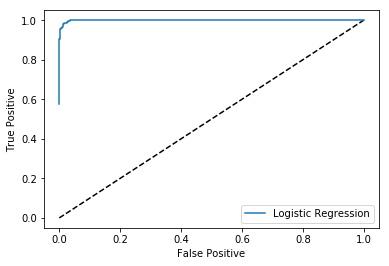

In [10]:
#plot the ROC curve for this model
y_pred_prob = lr.predict_proba(x_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, y_pred_prob)

plt.plot([0,1], [0,1], 'k--')

plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.legend()
plt.show()


## Findings

The first decision I made with the data was to fill in as many of the missing values as possible. The field last_session_creation_time had a number of missing values which I interpreted as a user never having signed on. I decided to fill this with the initial account creation time. Using the usage summary table, I calculated the time between the first and last session for each user, and the total number of sessions for each user. Using the criteria set forth, 3 visits in any 7 day period, I also calculated whether a user can be considered to have adopted or not. Exploring the data I found it interesting, although not unsurprising, that adopted users tended to sign on many more times that non-adopted users and that the time between sign-ons is much more variable for adopted users.

I chose to use a logistic regression to attempt to predict adoption. I only used five fields creation_source, opted_in_to_mailing_list, enabled_for_marketing_drip, time_between, total_visits as features choosing not to use creation_time, last_session_creation_time, name, or email because these fields would not be relevant to future users. This model correctly predicted adoption 98.8% of the time. Exploring the coefficients of the parameters we can look at the odd-ratios for each parameter. Total visits has the most influence on the model. For every subsequent visit, the odds that a user adopts increases almost 3.7 times. Of the creation sources, signing up via the website increases the odds of adoption the most, although they are all fairly similar.
